<img style="float: left;;" src='Figures/alinco.png' /></a>


# <center> <font color= #000047>  Módulo 1: Arboles de Desición

## Arboles de Desición


Los árboles de decisión, también conocidos como modelos de árbol de clasificación y regresión (CART), son métodos basados en árboles para el aprendizaje automático supervisado. Los árboles de clasificación y de regresión simples son fáciles de usar e interpretar, pero no son competitivos con los mejores métodos de aprendizaje automático. Sin embargo, forman la base para el conjunto de modelos de ensamblaje como “bagged trees”, “random forest” y “boosted trees”, que aunque son menos interpretables, son muy precisos.

Los modelos CART se puede definir en dos tipos de problemas

**Árboles de clasificación:** la variable resultado es categórica y el métodos se utiliza para identificar la “clase” dentro de la cual es más probable que caiga nuestra variable resultado. Un ejemplo de un problema de tipo clasificación sería determinar quién se suscribirá o no a una plataforma digital; o quién se graduará o no de la escuela secundaria; o si una persona tiene cáncer o no.

**Árboles de regressión:** la variable resultado es continua y el métodos se utiliza para predecir su valor. Un ejemplo de un problema de tipo regresión sería predecir los precios de venta de una casa residencial o el nivel de colesterol de una persona.


Un árbol de decisión es una secuencia de operadores relacionales organizados como árbol donde:

- Los atributos de un dato son evaluados desde la raiz hasta las hojas
- Los nodos hoja (terminales) están asociados a una clase
- Los nodos no-hoja están asociados a un operador lógico que divide los datos en dos o más conjuntos
- El operador lógico o *split* se aplica sobre un atributo (feature) de los datos

El siguiente diagrama ejemplifica el funcionamiento del árbol de decisión sobre un dataset con dos etiquetas y dos atributos (X y Z). 

<img src="Figures/tree.png" width="600">

- La figura izquierda muestra un árbol de decisión binario con 5 nodos: 3 nodos hoja y 2 nodos de decisión.
- La figura derecha muestra la partición que produce el árbol de decisión en el espacio de los datos. 
- Las separaciones o *splits* son siempre perpendiculares a los ejes de los datos (atributos).


Entrenar el árbol de decisión es el proceso de escoger los atributos, operadores y umbrales de separación en los nodos de decisión.


La función de costo más común para los árboles de regresión es la suma de los residuos al cuadrado,

$$RSS = \sum_{k=1}^{K}\sum_{i \ in A_k} (y_i - \hat{y}_{A_k})^2$$

Para árboles de clasificación, es el índice de Gini,

$$ G=\sum_{c=1}^C \hat{p}_{kc} (1-\hat{p}_{kc})$$

y la entropía (información estadística)

$$ E= - \sum_{c=1}^C \hat{p}_{kc} log(\hat{p}_{kc})$$

dónde $\hat{p}_{kc}$ es la proporción de observaciones de entrenamiento en el nodo $k$ que son de clase $c$. Un nodo completamente puro en un árbol binario tendría $\hat{p} \in \{0,1\}$ y $G=E=0$.  Un nodo completamente impuro en un árbol binario tendría $\hat{p}=0.5$ y $G=0.5^2*2 = 0.25$, y $E=- (0.5 \cdot log(0.5))\cdot 2 = 0.69$

La ganacia de información para un nodo que separa un conjunto de datos $D$ en dos $D_{izq}$ y $D_{der}$ es

$$
G(D; D_{izq}, D_{der}) = H(D) - \frac{|D_{izq}|}{|D|} H(D_{izq}) - \frac{|D_{der}|}{|D|} H(D_{der})
$$

donde $|A|$ es la cardinalidad del subconjunto $A$ y 

$$
H(A) = - \sum_{y \in \mathcal{Y}} p(y|A) \log p(y|A)
$$

es la entropía del subconjunto $A$. En la expresión anterior $p(y|A)$ es la frecuencia relativa de los ejemplos de clase $y$ dentro de $A$.

**La entropía mide la “pureza” del subconjunto en términos de sus clases. El subconjunto más puro es aquel donde todos los elementos son de la misma clase. El nodo más impuro es aquel en donde hay igual cantidad de elementos de cada clase (uniforme).**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import random

## Algoritmo

Sea el siguiente arreglo las etiquetas de un subconjunto de 12 ejemplos

In [2]:
labels = np.array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

Asumiendo que el problema sólo tiene dos clases las frecuencias relativas son

In [3]:
_, counts = np.unique(labels, return_counts=True)
counts/len(labels)

array([0.33333333, 0.66666667])

Y la entropía del conjunto sería:

In [4]:
def entropy(subset_labels):
    unique, counts = np.unique(subset_labels, return_counts=True)
    frequencies = counts/len(subset_labels)
    return -np.sum(frequencies*np.log2(frequencies+1e-16))

entropy(labels)

0.9182958340544893

La entropía es máxima si hay igual cantidad de ejemplos de ambas clases (mínima pureza)

In [5]:
B = np.array([1, 1, 1, 0, 0, 0])
entropy(B)

0.9999999999999997

y mínima si todos los ejemplos son de una clase  (máxima pureza)

In [6]:
C = np.array([1, 1, 1, 1, 1, 1])
entropy(C)

-0.0

**Extensión a más de dos clases**

Si un nodo separa el conjunto en $k$ subconjuntos la regla es


- En cada nodo se escoge el atributo que maximiza la ganancia de información.

Consideremos el siguiente problema:

In [7]:
import pandas as pd

data = {'tiempo': ['soleado', 'soleado', 'soleado', 'lluvioso', 'lluvioso'], 
        'humedad': ['baja', 'baja', 'alta', 'alta', 'alta'],
        'temperatura': ['templado', 'caluroso', 'caluroso', 'templado', 'frio']}

node = pd.DataFrame(data)
node

,tiempo,humedad,temperatura
0,soleado,baja,templado
1,soleado,baja,caluroso
2,soleado,alta,caluroso
3,lluvioso,alta,templado
4,lluvioso,alta,frio


donde queremos obtener un árbol de decisión que prediga el tiempo en función de la humedad y de la temperatura.

Para decidir cual variable debe ir en el primer nodo comparamos sus ganancias de información

In [8]:
def info_gain(subset, feature):
    subset_labels = subset["tiempo"].values
    entropy_root = entropy(subset_labels)
    entropy_nodes = []
    for unique_label in subset[feature].unique():
        split = subset.loc[subset[feature] == unique_label]
        split_labels = split["tiempo"].values
        entropy_nodes.append(entropy(split_labels)*len(split_labels)/len(subset_labels))
    return entropy_root - sum(entropy_nodes)


for feature in ["humedad", "temperatura"]:
    print(f"Ganancia de información de {feature}: {info_gain(node, feature):0.6f}")

Ganancia de información de humedad: 0.419973
Ganancia de información de temperatura: 0.570951


Temperatura tiene mayor ganancia que humedad, por lo tanto el primer nodo separador utiliza temperatura.

Si separamos por temperatura tenemos:

In [9]:
node.loc[node["temperatura"] == 'frio']

,tiempo,humedad,temperatura
4,lluvioso,alta,frio


En el caso `frio` se produce un nodo con un sólo ejemplo. El algoritmo no seguirá dividiendo.

In [10]:
node.loc[node["temperatura"] == 'caluroso']

,tiempo,humedad,temperatura
1,soleado,baja,caluroso
2,soleado,alta,caluroso


En el caso `caluroso` se produce un nodo con "puro". El algoritmo no seguirá dividiendo.

In [11]:
node.loc[node["temperatura"] == 'templado']

,tiempo,humedad,temperatura
0,soleado,baja,templado
3,lluvioso,alta,templado


En el caso `templado` el nodo no es puro, debemos nuevamente escoger un atributo para separar:

In [12]:
node = node.loc[node["temperatura"] == 'templado']
for feature in ["humedad", "temperatura"]:
    print(f"Ganancia de información de {feature}: {info_gain(node, feature)}")

Ganancia de información de humedad: 0.9999999999999997
Ganancia de información de temperatura: 0.0


Por lo tanto se escoge humedad, lo cual produce dos nodos puros (con un sólo ejemplo)

In [13]:
node.loc[node["humedad"] == 'baja']

,tiempo,humedad,temperatura
0,soleado,baja,templado


In [14]:
node.loc[node["humedad"] == 'alta']

,tiempo,humedad,temperatura
3,lluvioso,alta,templado


El algoritmo sigue separando el dataset de forma recursiva hasta que todos los nodos sean puros o hasta que se supere una profundidad máxima previamente designada.


### Train-Test-Split

In [15]:
def train_test_split(X_df, y_df, test_size):
    if isinstance(test_size, float):
        test_size= round(test_size*len(X_df))
    
    ind = X_df.index.to_list()
    test_indices = random.sample(population=ind, k = test_size)
    
    X_test_df = X_df.loc[test_indices]
    X_train_df = X_df.drop(test_indices)
    
    y_test_df = y_df.loc[test_indices]
    y_train_df = y_df.drop(test_indices)
    
    
    
    return X_train_df, X_test_df, y_train_df, y_test_df

## Creación de la clase de Arboles de Desicion


In [16]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            #print("X_"+str(tree.feature), "<=", tree.threshold, "?", tree.info_gain)
            print("X_"+str(tree.feature), "<=", tree.threshold, "?")
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
            

## Ejemplo 1

In [17]:
from sklearn import datasets
data = datasets.load_breast_cancer()
X, y = data.data, data.target

In [18]:
X_df=pd.DataFrame(X)
y_df=pd.DataFrame(y)

In [19]:
X_train_df, X_test_df, y_train_df, y_test_df =train_test_split(X_df, y_df,0.2)

In [20]:
y_train_df.values.flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,

In [21]:
clf = DecisionTree(min_samples_split=3,max_depth=3)
clf.fit(X_train_df.values, y_train_df.values.flatten())
predictions = clf.predict(X_test_df.values)

In [22]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test_df.values.flatten(), predictions)
print(acc)

0.8947368421052632


In [23]:
clf.print_tree()

X_22 <= 105.9 ?
 left:X_26 <= 0.3911 ?
  left:X_28 <= 0.1565 ?
    left:0
    right:1
  right:X_23 <= 476.4 ?
    left:1
    right:0
 right:X_27 <= 0.1489 ?
  left:X_21 <= 19.25 ?
    left:1
    right:0
  right:0


## Ejemplo 2:

In [24]:
df_iris = pd.read_csv('Data/Iris.csv', index_col=[0])

In [25]:
df_iris.head()

,sepal-length,sepal-width,petal-length,petal-width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [26]:
df_iris['Class_code']=df_iris['Class'].astype('category').cat.codes


In [27]:
df_iris

,sepal-length,sepal-width,petal-length,petal-width,Class,Class_code
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


In [28]:
X_df = df_iris.iloc[:,:4]
y_df = df_iris.iloc[:,5]

In [29]:
X_df.head()

,sepal-length,sepal-width,petal-length,petal-width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [30]:
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: Class_code, dtype: int8

In [31]:
y_df.unique()

array([0, 1, 2], dtype=int8)

In [32]:
X_train_df, X_test_df, y_train_df, y_test_df =train_test_split(X_df, y_df,0.2)

In [33]:
clf = DecisionTree(max_depth=2)
clf.fit(X_train_df.values, y_train_df.values.flatten())
predictions = clf.predict(X_test_df.values)

In [34]:
predictions

array([1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 1, 0,
       1, 1, 2, 1, 2, 1, 1, 1], dtype=int8)

In [35]:
y_test_df.values.flatten()

array([1, 1, 0, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 1, 0,
       1, 1, 2, 0, 2, 1, 1, 1], dtype=int8)

In [36]:
acc = accuracy(y_test_df.values.flatten(), predictions)
print(acc)

0.9


## Implementación en scikit-learn

El módulo [`tree`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) de scikit-learn tiene implementaciones de árboles de decisión para problemas de clasificación y regresión. Nos enfocaremos en la primera.

Los principales argumentos de [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) son:

- `criterion`: El criterio que se utiliza para escoger los *splits*, las opciones son `'gini'` y `'entropy'`
- `max_depth`: Límite para la profundidad máxima del árbol
- `min_samples_split`: El número mínimo de ejemplos en un nodo para realizar un *split*
- `min_samples_leaf`: El número mínimo de ejemplos que pueden estar en un nodo hoja
- `min_impurity_decrease`: La disminución de pureza mínima en un nodo para realizar un *split*
- `class_weight`: Permite asignar ponderación a las clases, es de utilidad si se tienen clases medianamente desbalanceadas
- `max_features`: El número máximo de atributos a considerar en cada *split*


Si se utilizan los argumentos (hiperparámetros) por defecto el árbol crecera hasta que sus nodos sean todos puros. Esto en general produce árboles de gran profundidad (muy capaces de sobreajustarse). 

Se puede limitar el tamaño de un árbol aumentando `min_samples_leaf` y/o `min_samples_split`, o disminuyendo `max_depth`.



Los principales métodos son:

- `predict(X)`: Retorna la clase predicha
- `predict_proba(X)`: Retorna las probabilidades de pertenecer a cada una de las clases
- `score(X,y)`: Retorna el *accuracy* de clasificación
- `get_params()`: Retorna los nombres de los parámetros

Además tiene algunos métodos no compartidos con otros estimadores como

- `get_depth()`: Retorna la profunidad del árbol aprendido
- `get_n_leaves()`: Retorna la cantidad de nodos hoja del árbol aprendida
- `apply(X)`: Retorna el índice de la hoja que predice cada ejemplo



In [37]:
X_train_df

,sepal-length,sepal-width,petal-length,petal-width
0,5.1,3.5,1.4,0.2
2,4.7,3.2,1.3,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
...,...,...,...,...
141,6.9,3.1,5.1,2.3
142,5.8,2.7,5.1,1.9
143,6.8,3.2,5.9,2.3
145,6.7,3.0,5.2,2.3


In [38]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train_df, y_train_df)

DecisionTreeClassifier(criterion='entropy')

In [39]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best ran

In [40]:
model.get_depth()

4

In [41]:
model.score(X_test_df, y_test_df)

0.9666666666666667

Podemos utilizar la función [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) para obtener una visualización del árbol de decisión. En cada nodo se muestra:

- El atributo y umbral seleccionados.
- El valor del criterio (índice de gini).
- La cantidad de ejemplos que entraron al nodo.
- La cantidad de ejemplos que entraron al nodo separados por clase (en este caso tres).


In [42]:
df_iris.columns[:-2].to_list()

['sepal-length', 'sepal-width', 'petal-length', 'petal-width']

In [43]:
X_names =  df_iris.columns[:-2].to_list()

In [44]:
X_train_df.shape

(120, 4)

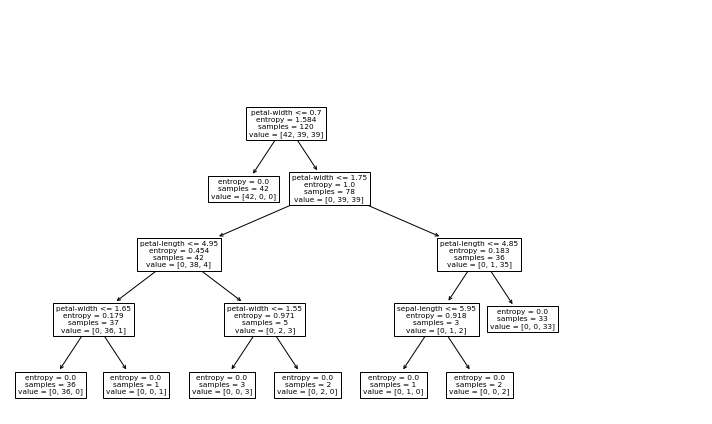

In [45]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
plot_tree(model, feature_names=X_names, ax=ax);

In [46]:
help(plot_tree)

Help on function plot_tree in module sklearn.tree._export:

plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rotate='deprecated', rounded=False, precision=3, ax=None, fontsize=None)
    Plot a decision tree.
    
    The sample counts that are shown are weighted with any sample_weights that
    might be present.
    
    The visualization is fit automatically to the size of the axis.
    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
    the size of the rendering.
    
    Read more in the :ref:`User Guide <tree>`.
    
    .. versionadded:: 0.21
    
    Parameters
    ----------
    decision_tree : decision tree regressor or classifier
        The decision tree to be plotted.
    
    max_depth : int, default=None
        The maximum depth of the representation. If None, the tree is fully
        generated.
    
    feature_names : list of strings, defa